### Import libraries

In [69]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import shap
# from captum.attr import IntegratedGradients, ShapleyValueSampling
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import math
import itertools

from libs.models import *

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

# Import data

In [70]:
# read data
df = pd.read_csv('data/data.csv')

# Prepare data for training

In [71]:
# prepare expanding window splits
periods = {
    '21' : '2020-01-01', # 2021 is the test set
    # '22' : '2021-01-01', # 2022 is the test set
    # '23' : '2022-01-01', # 2023 is the test set
    # '24': '2023-01-01' # 2024 is the test set
}

# identify dummy vs. numeric columns
feature_cols = [col for col in df.columns if col not in ['timestamp', 'ticker', 'target']]
nace_cols = [c for c in feature_cols if c.startswith('NACE_')]
dummy_cols = ['divi','divo'] # sin removed
macro_cols = ['discount', 'tms', 'dp', 'ep', 'svar'] # 'bm_macro'

# nummeric cols = cols not in cat and macro cols
numeric_cols = [c for c in feature_cols if c not in dummy_cols and c not in nace_cols and c not in macro_cols]

# feature_cols = numeric_cols + dummy_cols + nace_cols # reorder columns to have numeric first

df_raw = df.copy(deep=True)
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])

# drop data from 2025
df_raw = df_raw[df_raw['timestamp'] < '2025-01-01']

In [72]:
C = df[numeric_cols].values         # shape = (n_rows, P_c)
X = df[macro_cols].values           # shape = (n_rows, P_x)

# 1) compute all pairwise products with broadcasting:
#    this gives shape (n_rows, P_c, P_x)
K = C[:,:,None] * X[:,None,:]

# 2) reshape to (n_rows, P_c * P_x)
Z = K.reshape(len(df), -1)

# 3) build the column names in the same order
xc_names = [
    f"{c}_x_{m}"
    for c in numeric_cols
    for m in macro_cols
]

# 4) wrap back into a DataFrame
df_xc = pd.DataFrame(Z, columns=xc_names, index=df.index)

feature_cols = numeric_cols + xc_names + dummy_cols + nace_cols
numeric_cols = numeric_cols + xc_names
cat_cols = dummy_cols + nace_cols
df_z = df_raw.merge(df_xc, left_index=True, right_index=True)
# drop macro_cols
df_z = df_z.drop(columns=macro_cols)
# sort columns by feature_cols
df_norm = df_z[['timestamp', 'ticker', 'target'] + feature_cols]

y_values = df_norm['target'].values.astype('float32')


In [73]:
# prepare containers
X_train, X_val, X_test = {}, {}, {}
y_train, y_val, y_test = {}, {}, {}
preprocessors = {}

for y, period in periods.items():
    period = pd.to_datetime(period)

    # split masks
    tr_mask = df_norm['timestamp'] < period
    va_mask = (df_norm['timestamp'] >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=1) < period)
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    # extract raw feature DataFrames
    X_tr_df = df_norm.loc[tr_mask, feature_cols].copy()
    X_va_df = df_norm.loc[va_mask, feature_cols].copy()
    X_te_df = df_norm.loc[te_mask, feature_cols].copy()
    y_tr    = y_values[tr_mask]
    y_va    = y_values[va_mask]
    y_te    = y_values[te_mask]

    # compute winsorization bounds on train
    lower = X_tr_df[numeric_cols].quantile(0.01)
    upper = X_tr_df[numeric_cols].quantile(0.99)

    # apply clipping to train, val, test
    X_tr_df[numeric_cols] = X_tr_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_va_df[numeric_cols] = X_va_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_te_df[numeric_cols] = X_te_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)


    # now fit scaler on numeric only
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough',  cat_cols)
    ])
    preprocessor.fit(X_tr_df)
    preprocessors[y] = preprocessor

    # transform all splits
    X_train[y] = preprocessor.transform(X_tr_df).astype('float32')
    X_val[y]   = preprocessor.transform(X_va_df).astype('float32')
    X_test[y]  = preprocessor.transform(X_te_df).astype('float32')

    # store targets as before
    y_train[y] = y_tr.reshape(-1, 1)
    y_val[y]   = y_va.reshape(-1, 1)
    y_test[y]  = y_te.reshape(-1, 1)


In [88]:
# moving to metal or CUDA GPU if available
device = torch.device(("cuda" if torch.cuda.is_available() 
                       else "mps" if torch.backends.mps.is_available() 
                       else "cpu"))
print("Using device:", device)

# general hyperparameters
hidden_depth = 3 # only hidden, excluding in- and output layers
hidden_width = [32,16,8] # int for all being equal width; list for different widths
learning_rate = 1e-4 # increased from 1e-4 as we have full batching
activation_fun = nn.ReLU # # nn.ReLU nn.Tanh nn.Sigmoid nn.LeakyReLU nn.Identity

# general critereon and regularization parameters
criterion = nn.MSELoss()
lambda_l1 = 1e-4 # 1e-3 # currently 0 
lambda_l2 = 1e-4 # l2 regularization
drop = 0.0

# general parmeters
patience = 25
print_freq = 100
epochs = 250
batch_size = 4096 # 8192 # 16384 # 2^1X adjust to your memory


Using device: mps


# Test hyperparameters

## Constant scheme

In [97]:
# training model with most data on multiple parameters
l1_space = [lambda_l1] # [0.0]
l2_space = [lambda_l2] # [1e-4, 1e-3, 5e-3, 1e-2] # np.geomspace(1e-4, 1e-2, num=4)
dropout_space = [drop] # [0.0, 0.1, 0.2, 0.3] # np.geomspace(0.0, 0.3, num=4)
learning_rate_space = [learning_rate] # np.geomspace(1e-4, 5e-3, num=4)
depth_space = [1, 2, 3, 4, 5, 6, 7] # [1, 2, 3]
width_space = [8, 16, 32, 64, 128] # [32, 64, 128]

In [76]:
# current runtime: 4h 35m
best_models_size = {}
history_size = {}
models_21 = {}
year = '21'
n_runs = 5

for lambda_l1 in l1_space:
    for lambda_l2 in l2_space:
        for dropout in dropout_space:
            for learning_rate in learning_rate_space:
                for hidden_depth in depth_space:
                    for hidden_width in width_space:
                        print(f"""Training model for year '{year}...: 
                                lambda_l1       ={lambda_l1:.0e}
                                lambda_l2       ={lambda_l2:.0e}
                                dropout         ={dropout:.0e}
                                learning_rate   ={learning_rate:.0e}
                                hidden_depth    ={hidden_depth}
                                hidden_width    ={hidden_width}""")
                        for run in range(n_runs):
                            print(f"Run {run+1} of {n_runs}")
                            seed = 42+run   
                            np.random.seed(seed)
                            torch.manual_seed(seed)
                            # Initialize the model
                            input_dim = X_train[year].shape[1]
                            name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}'
                            models_21[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
                            optimizer = torch.optim.Adam(models_21[name].parameters(), lr=learning_rate)
                            train = MLPdataset(X_train[year], y_train[year])
                            val = MLPdataset(X_val[year], y_val[year])
                            best_models_size[name], history_size[name] = train_mlp(train,          
                                                            val,
                                                            models_21[name],
                                                            criterion,
                                                            epochs,
                                                            patience,
                                                            print_freq,
                                                            device,
                                                            optimizer,
                                                            lambda_l1=lambda_l1,
                                                            lambda_l2=lambda_l2,
                                                            batch_size=batch_size,
                                                            shuffle_train=True,
                                                            shuffle_val=False,
                                                            save_path=f'models/hyperparam_test/mlp_y{year}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}.pth'
                                                            )

Training model for year '21...: 
                                lambda_l1       =1e-04
                                lambda_l2       =1e-04
                                dropout         =0e+00
                                learning_rate   =1e-04
                                hidden_depth    =1
                                hidden_width    =8
Run 1 of 5
Epoch 100/250  - Train Loss: 2.43394E-02  - Val Loss: 2.07440E-02
Epoch 200/250  - Train Loss: 2.37068E-02  - Val Loss: 2.03020E-02
Early stopping at epoch 225
Best val loss: 2.03020E-02
Model saved to models/hyperparam_test/mlp_y21_l10.0001_l20.0001_drop0.0_lr0.0001_w8_d1_run1.pth
Run 2 of 5
Epoch 100/250  - Train Loss: 2.48385E-02  - Val Loss: 2.01433E-02
Epoch 200/250  - Train Loss: 2.41557E-02  - Val Loss: 1.99527E-02
Early stopping at epoch 201
Best val loss: 1.99398E-02
Model saved to models/hyperparam_test/mlp_y21_l10.0001_l20.0001_drop0.0_lr0.0001_w8_d1_run2.pth
Run 3 of 5
Epoch 100/250  - Train Loss: 2.48113E-02  - Va

In [ ]:
# device = torch.device('cpu')
# criterion = nn.MSELoss()
# val = MLPdataset(X_val[year], y_val[year])

# for hidden_depth in depth_space:
#     for hidden_width in width_space:
#         for dropout in dropout_space:
#             for lambda_l2 in l2_space:
#                 for lambda_l1 in l1_space:
#                     for learning_rate in learning_rate_space:
#                         for run in range(n_runs):
#                             name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}'
#                             load_path = (
#                                 f"models/hyperparam_test/mlp_y{year}" # error in prev code
#                                 f"_l1{lambda_l1}"
#                                 f"_l2{lambda_l2}"
#                                 f"_drop{dropout}"
#                                 f"_lr{learning_rate}"
#                                 f"_w{hidden_width}"
#                                 f"_d{hidden_depth}"
#                                 f"_run{run+1}.pth"
#                             )
#                             model = MLPModel(
#                                 input_dim  = X_train[year].shape[1],
#                                 depth      = hidden_depth,
#                                 width      = hidden_width,
#                                 dropout    = dropout,
#                                 activation = activation_fun,
#                             ).to(device)
#                             model.load_state_dict(torch.load(load_path, map_location=device))
#                             model.eval()
#                             best_models_size[name] = model

#     val_loader  = DataLoader(val, batch_size=batch_size, shuffle=False)

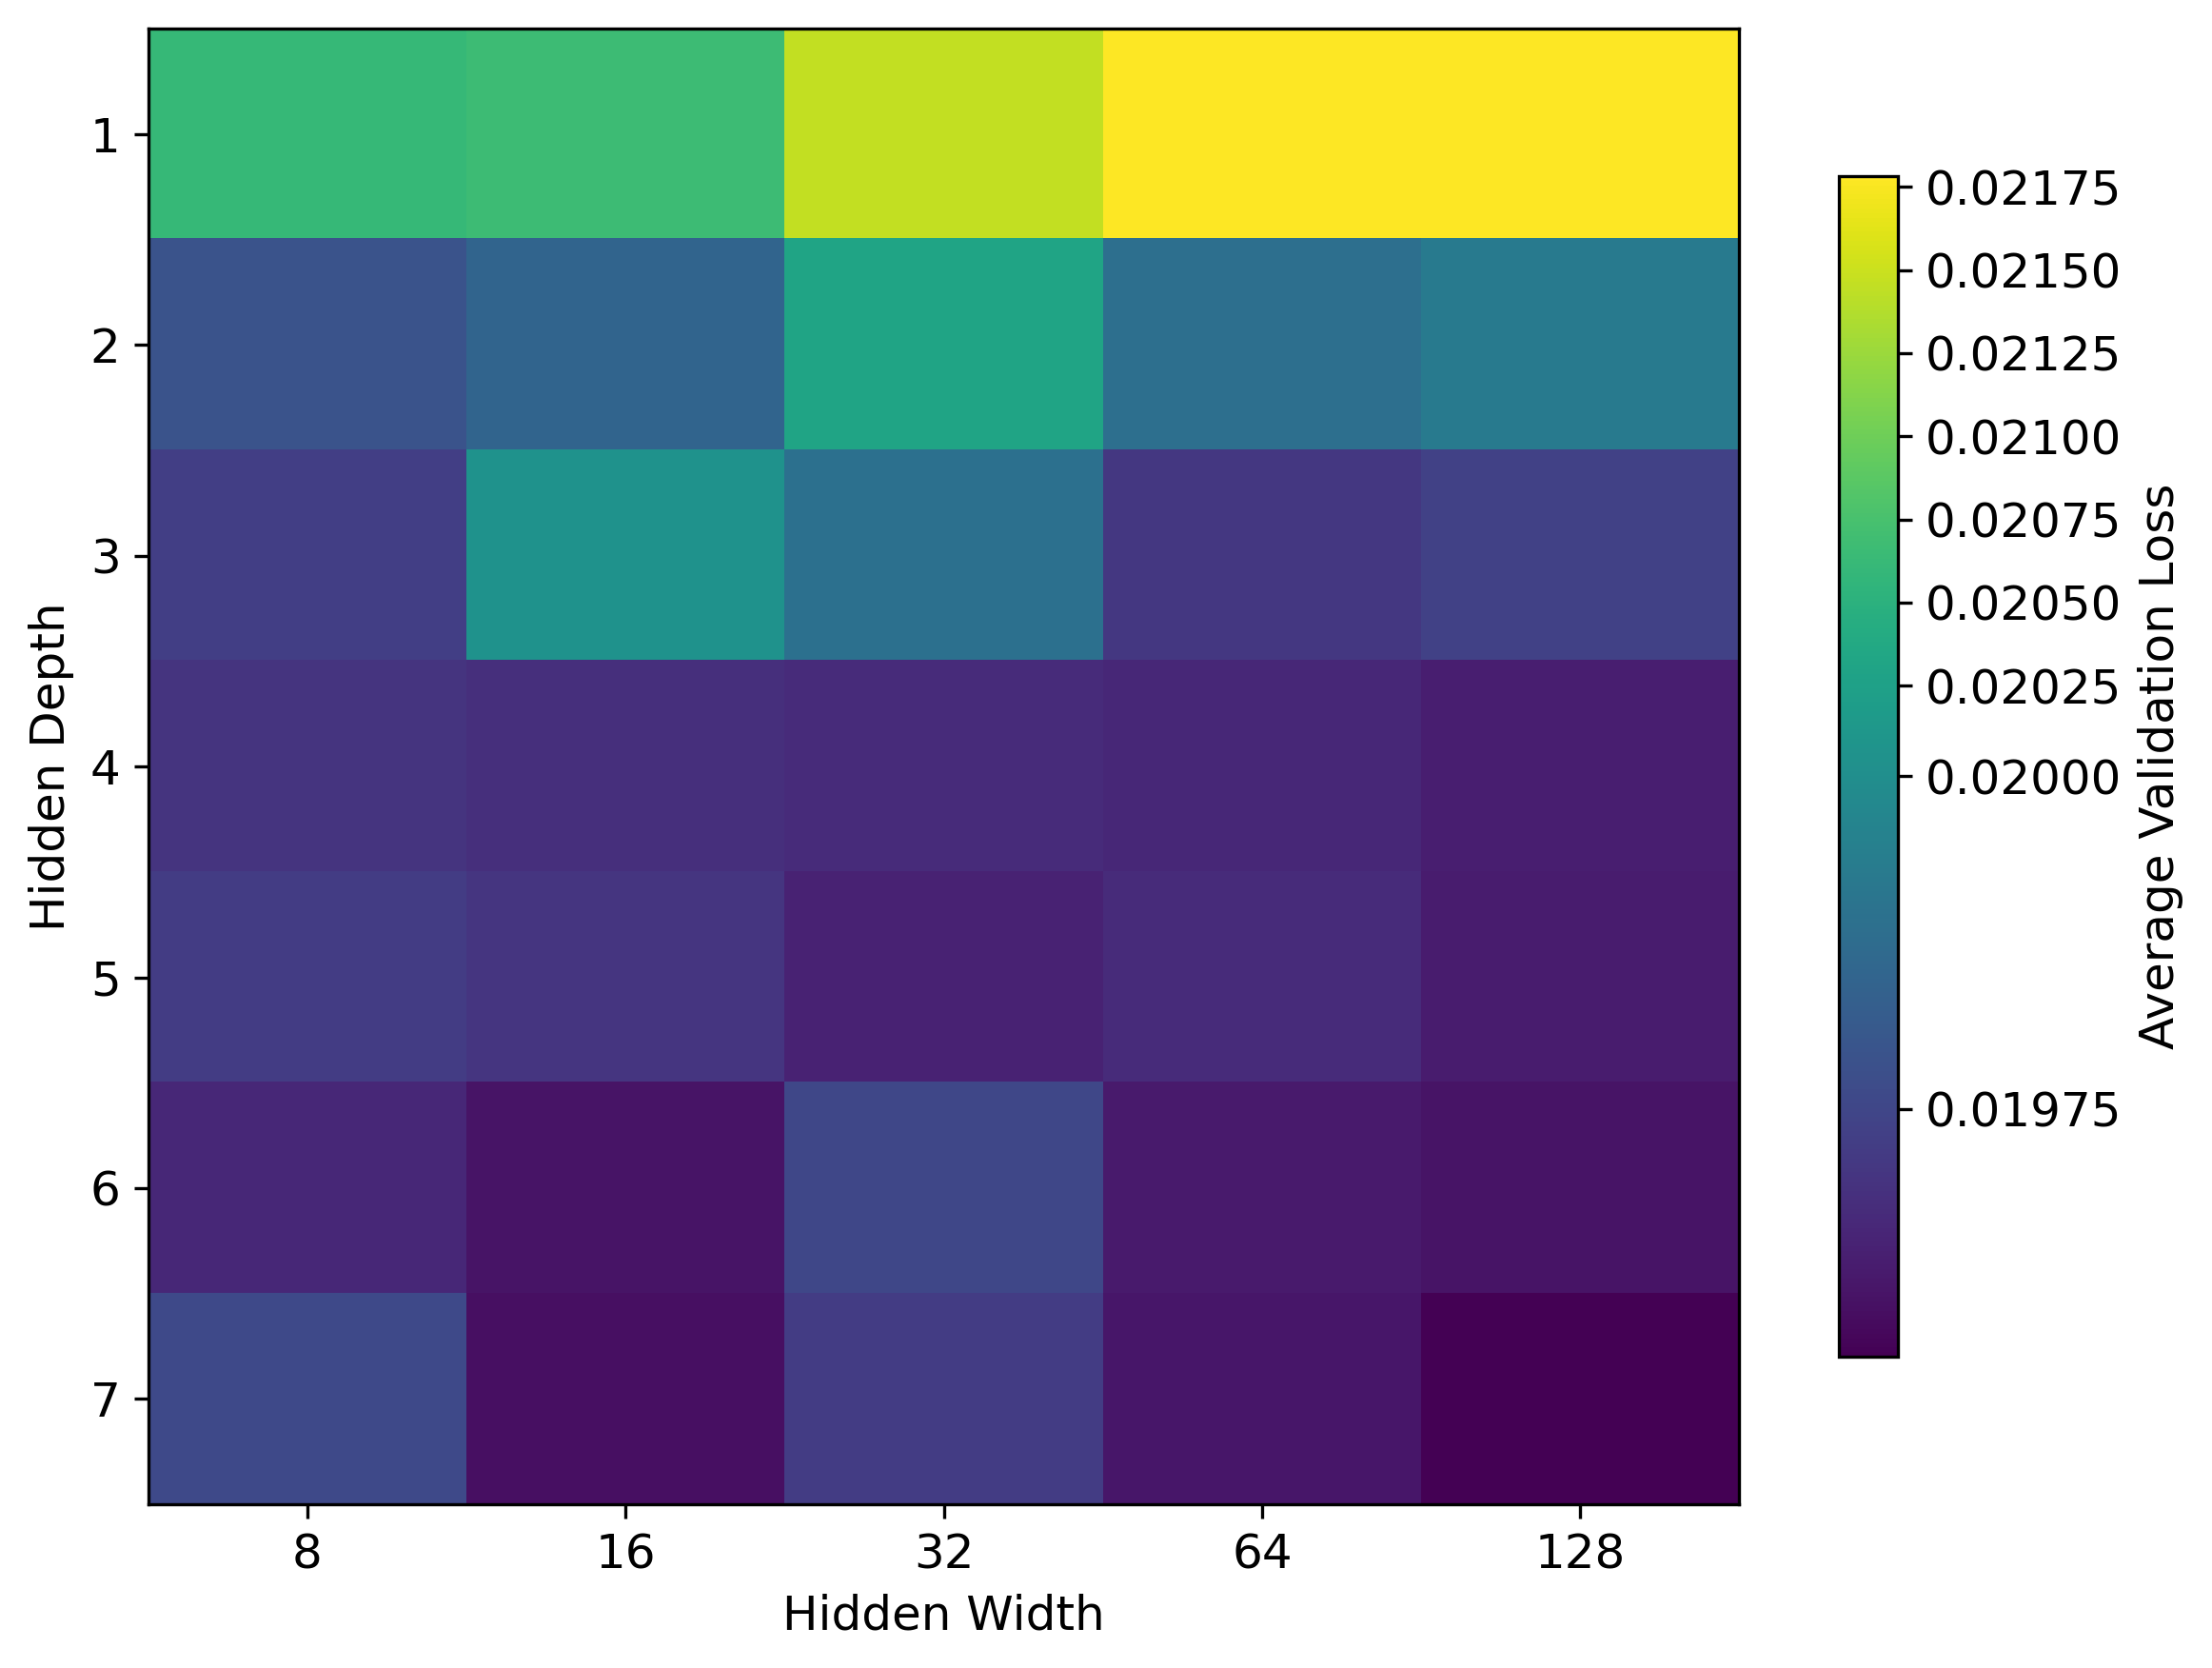

In [98]:
device    = torch.device('cpu')
criterion = nn.MSELoss()

# build your validation DataLoader once
val_dataset = MLPdataset(X_val[year], y_val[year])
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# pick a single dropout & learning rate (or loop over them similarly if you like)
dropout       = dropout_space[0]
learning_rate = learning_rate_space[0]

n_runs  = 5  # number of seeds
D       = len(depth_space)
W       = len(width_space)
loss_mat = np.zeros((D, W), dtype=float)

# for each architecture, average over the n_runs different seeds
for di, hidden_depth in enumerate(depth_space):
    for wj, hidden_width in enumerate(width_space):
        run_losses = []
        for run in range(n_runs):
            fname = (
                f"models/hyperparam_test/mlp_y{year}"
                f"_l1{lambda_l1}_l2{lambda_l2}"
                f"_drop{dropout}_lr{learning_rate}"
                f"_w{hidden_width}_d{hidden_depth}"
                f"_run{run+1}.pth"
            )
            model = MLPModel(
                input_dim  = X_train[year].shape[1],
                depth      = hidden_depth,
                width      = hidden_width,
                dropout    = dropout,
                activation = activation_fun,
            ).to(device)

            model.load_state_dict(torch.load(fname, map_location=device))
            model.eval()

            # compute this seed’s val‐loss
            losses = []
            with torch.no_grad():
                for Xb, yb in val_loader:
                    Xb, yb = Xb.to(device), yb.to(device)
                    yp     = model(Xb)
                    losses.append(criterion(yp, yb).item())
            run_losses.append(np.mean(losses))

        # store the mean across seeds
        loss_mat[di, wj] = np.mean(run_losses)

# set up a TwoSlopeNorm to stretch low‐loss differences
vmin    = loss_mat.min()
vmax    = loss_mat.max()
vcenter = vmin + 0.2*(vmax - vmin)
norm    = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# plot single heatmap: rows=depth, cols=width
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(loss_mat, aspect='auto', cmap='viridis', norm=norm)

ax.set_xticks(np.arange(W))
ax.set_xticklabels(width_space)
ax.set_yticks(np.arange(D))
ax.set_yticklabels(depth_space)
ax.set_xlabel('Hidden Width')
ax.set_ylabel('Hidden Depth')

cbar = fig.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Average Validation Loss')

plt.tight_layout()
fig.savefig('figs/valloss_heat_width_depth.png', dpi=300)
plt.show()

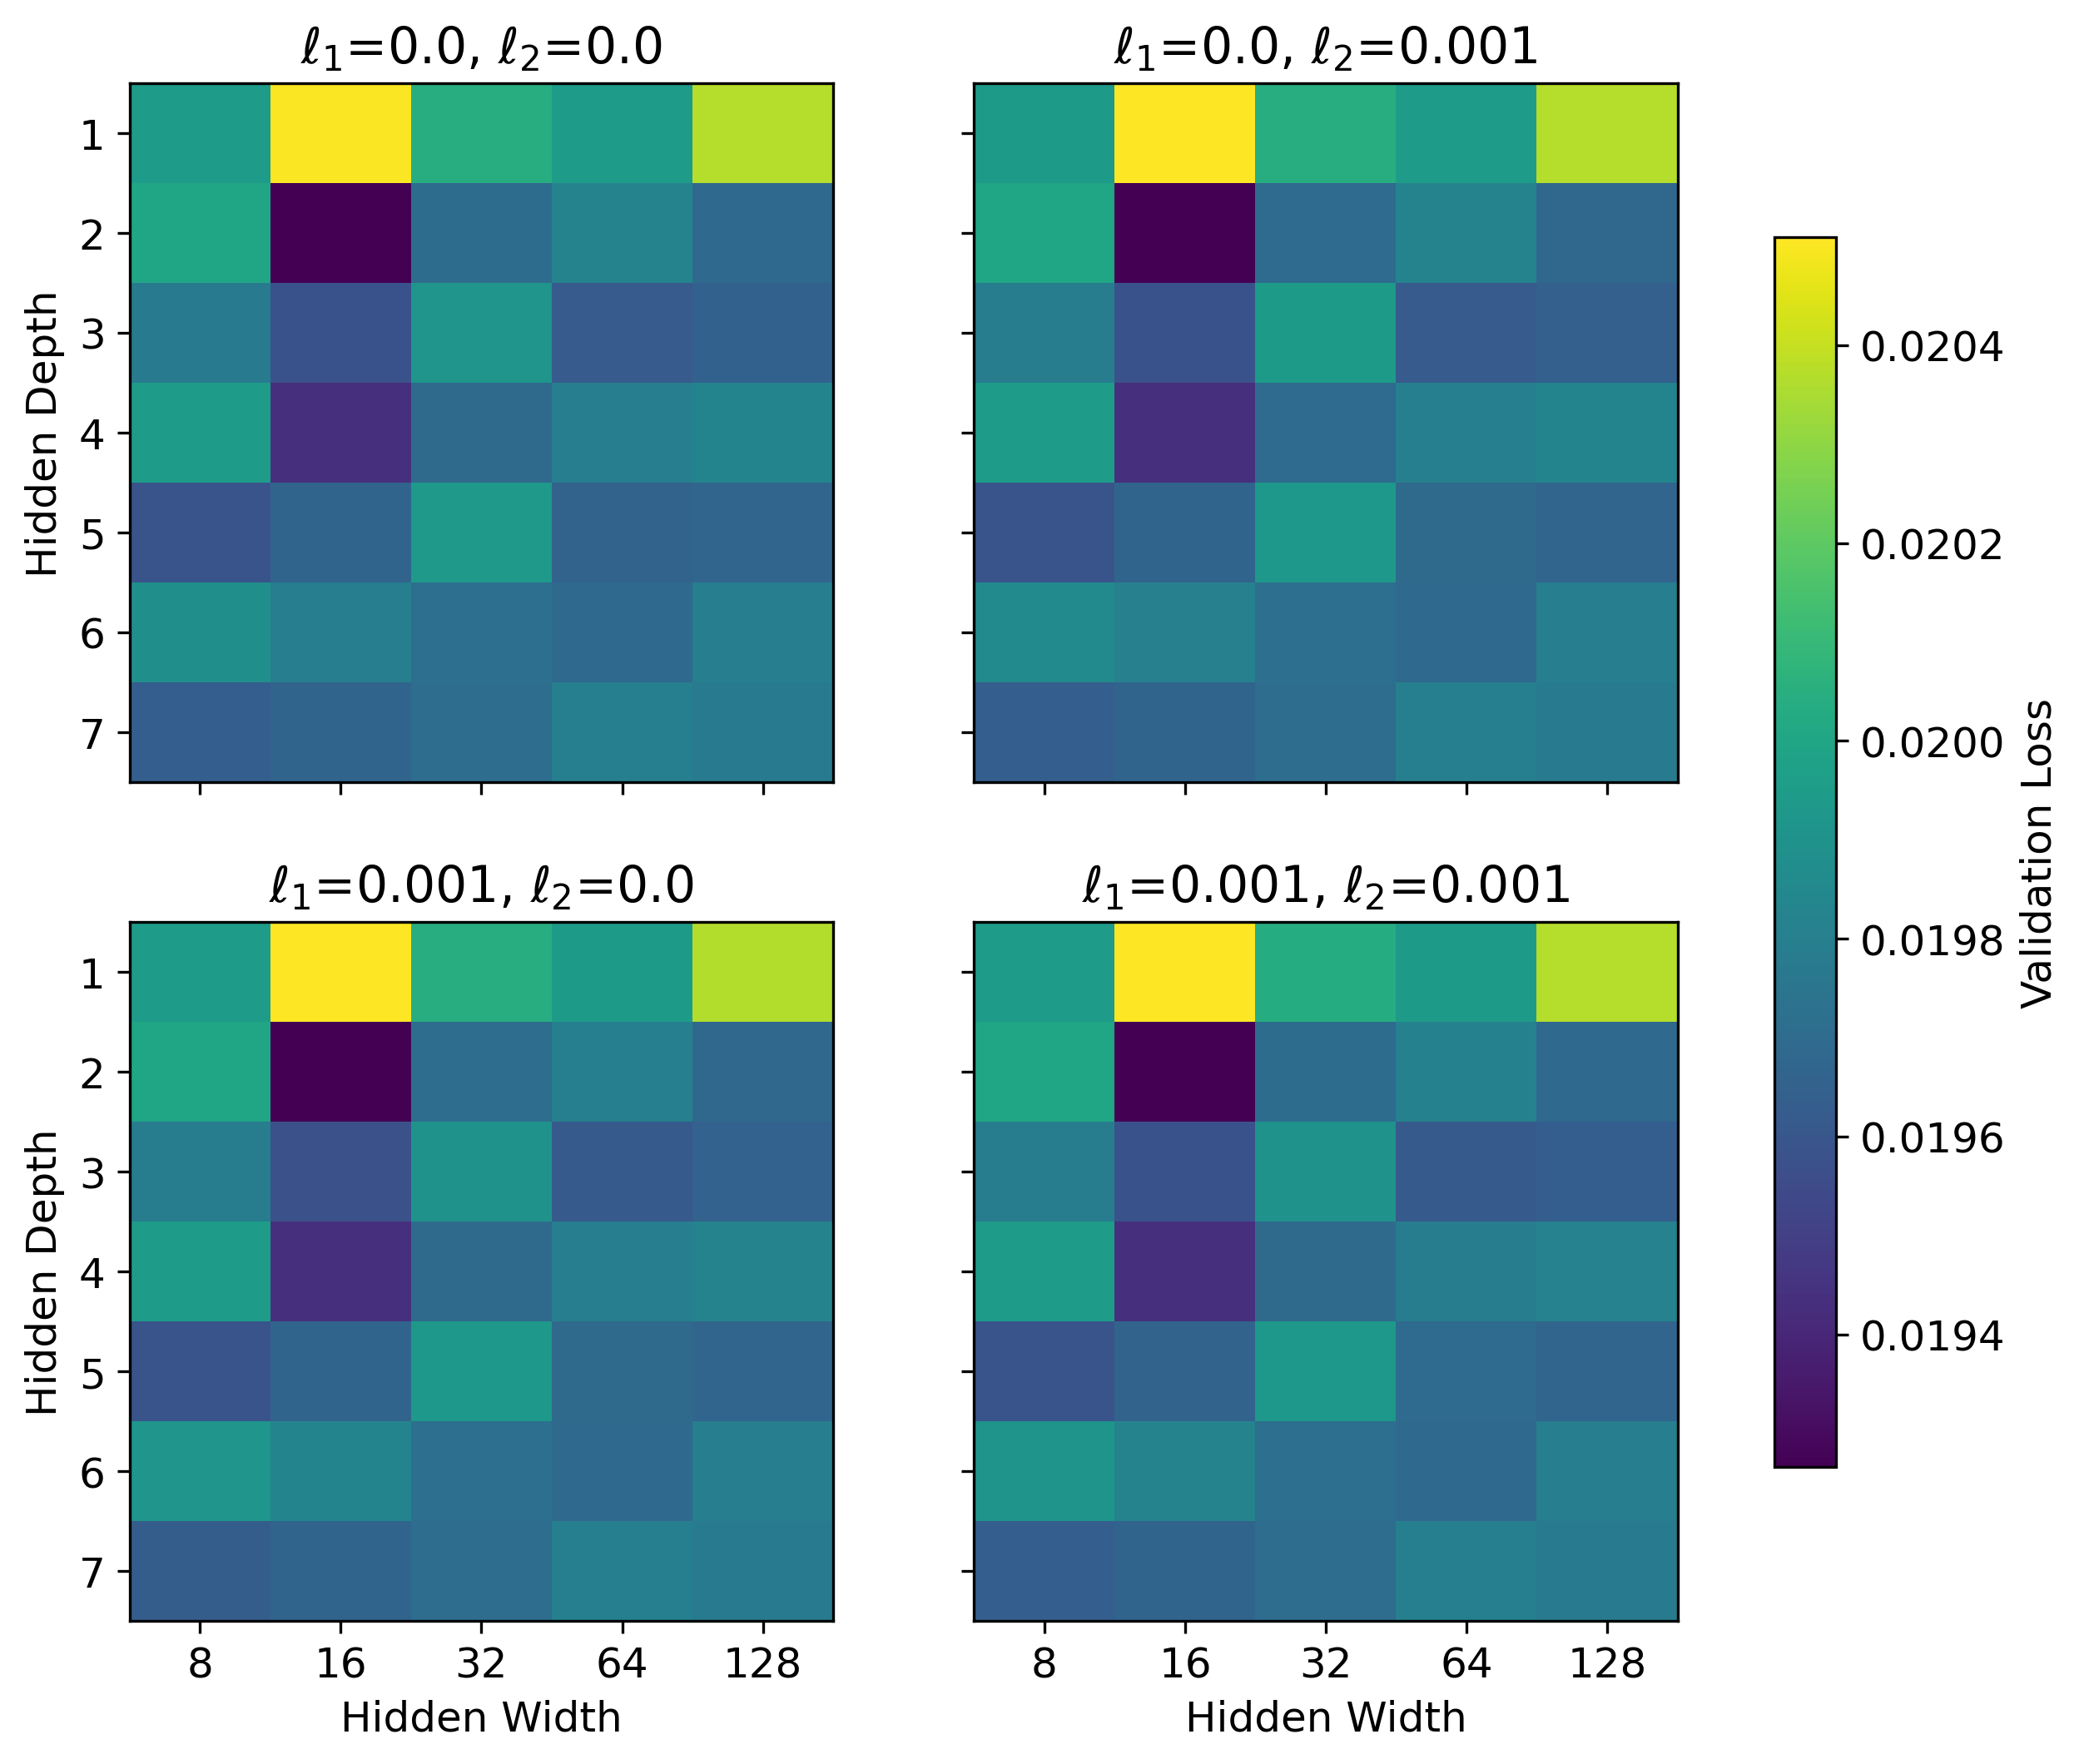

In [ ]:
# n_l1 = len(l1_space)
# n_l2 = len(l2_space)

# # first pass: build and collect all the loss‐matrices so we can compute a global vmin/vmax
# all_losses = []
# loss_matrices = [[None]*n_l2 for _ in range(n_l1)]
# for i, lambda_l1 in enumerate(l1_space):
#     for j, lambda_l2 in enumerate(l2_space):
#         mat = np.zeros((len(depth_space), len(width_space)))
#         for di, hidden_depth in enumerate(depth_space):
#             for wj, hidden_width in enumerate(width_space):
#                 name = (
#                     f"l1{lambda_l1}_l2{lambda_l2}"
#                     f"_drop{dropout_space[0]}_lr{learning_rate_space[0]}"
#                     f"_w{hidden_width}_d{hidden_depth}"
#                 )
#                 model = best_models_size[name]
#                 model.eval()
#                 losses = []
#                 with torch.no_grad():
#                     for Xb, yb in val_loader:
#                         Xb, yb = Xb.to(device), yb.to(device)
#                         yp     = model(Xb)
#                         losses.append(criterion(yp, yb).item())
#                 mat[di, wj] = np.mean(losses)
#         loss_matrices[i][j] = mat
#         all_losses.append(mat)

# # global min/max
# vmin = np.min(all_losses)
# vmax = np.max(all_losses)
# # pick a center low in the range to "stretch" the bottom end
# vcenter = vmin + 0.5*(vmax - vmin)

# norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
# cmap = 'viridis'

# fig, axes = plt.subplots(n_l1, n_l2, figsize=(5 * n_l2, 4 * n_l1), squeeze=False)

# for i in range(n_l1):
#     for j in range(n_l2):
#         ax = axes[i, j]
#         mat = loss_matrices[i][j]
#         im = ax.imshow(mat, aspect='auto', cmap=cmap, norm=norm)

#         # ticks & labels
#         ax.set_xticks(np.arange(len(width_space)))
#         ax.set_xticklabels(width_space)
#         ax.set_yticks(np.arange(len(depth_space)))
#         ax.set_yticklabels(depth_space)

#         # only bottom row: show x-axis label
#         if i == n_l1 - 1:
#             ax.set_xlabel('Hidden Width')
#         else:
#             ax.tick_params(labelbottom=False)

#         # only left column: show y-axis label
#         if j == 0:
#             ax.set_ylabel('Hidden Depth')
#         else:
#             ax.tick_params(labelleft=False)

#         # title for each panel
#         lambda_l1 = l1_space[i]
#         lambda_l2 = l2_space[j]
#         ax.set_title(f"$\\ell_1$={lambda_l1}, $\\ell_2$={lambda_l2}")

# # shared colorbar
# cbar = fig.colorbar(im, ax=axes.flatten().tolist(), shrink=0.8)
# cbar.set_label('Validation Loss')

# # save the figure
# fig.savefig('figs/valloss_heat_size.png', dpi=300)

# # plt.tight_layout()
# plt.show()

## Pyramid scheme

In [100]:
# training model with most data on multiple parameters
l1_space = [lambda_l1] # [0.0]
l2_space = [lambda_l2] # [1e-4, 1e-3, 5e-3, 1e-2] # np.geomspace(1e-4, 1e-2, num=4)
dropout_space = [drop] # [0.0, 0.1, 0.2, 0.3] # np.geomspace(0.0, 0.3, num=4)
learning_rate_space = [learning_rate] # np.geomspace(1e-4, 5e-3, num=4)
# depth_space = [1, 2, 3, 4, 5, 6, 7, 8] # [1, 2, 3]
width_space = [[32], [32, 16], [32, 16, 8], [32, 16, 8, 4], [32,16,8,4,2]] # [32, 64, 128]

In [80]:
best_models_pyramid = {}
history_pyramid = {}
for lambda_l1 in l1_space:
    for lambda_l2 in l2_space:
        for dropout in dropout_space:
            for learning_rate in learning_rate_space:
                for hidden_width in width_space:
                    hidden_depth = len(hidden_width)
                    print(f"""Training model for year '{year}...: 
                            lambda_l1       ={lambda_l1:.0e}
                            lambda_l2       ={lambda_l2:.0e}
                            dropout         ={dropout:.0e}
                            learning_rate   ={learning_rate:.0e}
                            hidden_depth    ={hidden_depth}
                            hidden_width    ={hidden_width}""")
                    for run in range(n_runs):
                        print(f"Run {run+1} of {n_runs}")
                        seed = 42+run
                        np.random.seed(seed)
                        torch.manual_seed(seed)
                        # Initialize the model
                        input_dim = X_train[year].shape[1]
                        name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}'
                        models_21[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
                        optimizer = torch.optim.Adam(models_21[name].parameters(), lr=learning_rate)
                        train = MLPdataset(X_train[year], y_train[year])
                        val = MLPdataset(X_val[year], y_val[year])
                        best_models_pyramid[name], history_pyramid[name] = train_mlp(train,          
                                                        val,
                                                        models_21[name],
                                                        criterion,
                                                        epochs,
                                                        patience,
                                                        print_freq,
                                                        device,
                                                        optimizer,
                                                        lambda_l1=lambda_l1,
                                                        lambda_l2=lambda_l2,
                                                        batch_size=batch_size,
                                                        shuffle_train=True,
                                                        shuffle_val=False,
                                                        save_path=f'models/hyperparam_test/mlp_y{year}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}.pth'
                                                        )

Training model for year '21...: 
                            lambda_l1       =1e-04
                            lambda_l2       =1e-04
                            dropout         =0e+00
                            learning_rate   =1e-04
                            hidden_depth    =1
                            hidden_width    =[32]
Run 1 of 5
Epoch 100/250  - Train Loss: 2.30012E-02  - Val Loss: 2.05463E-02
Early stopping at epoch 125
Best val loss: 2.05463E-02
Model saved to models/hyperparam_test/mlp_y21_l10.0001_l20.0001_drop0.0_lr0.0001_w[32]_d1_run1.pth
Run 2 of 5
Epoch 100/250  - Train Loss: 2.35545E-02  - Val Loss: 2.25159E-02
Early stopping at epoch 132
Best val loss: 2.24409E-02
Model saved to models/hyperparam_test/mlp_y21_l10.0001_l20.0001_drop0.0_lr0.0001_w[32]_d1_run2.pth
Run 3 of 5
Epoch 100/250  - Train Loss: 2.33057E-02  - Val Loss: 2.17520E-02
Early stopping at epoch 164
Best val loss: 2.16428E-02
Model saved to models/hyperparam_test/mlp_y21_l10.0001_l20.0001_drop0.0_

In [94]:
device = torch.device('cpu')
criterion = nn.MSELoss()
val = MLPdataset(X_val[year], y_val[year])


for hidden_width in width_space:
    hidden_depth = len(hidden_width)
    for dropout in dropout_space:
        for lambda_l2 in l2_space:
            for lambda_l1 in l1_space:
                for learning_rate in learning_rate_space:
                    name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}'
                    load_path = (
                        f"models/hyperparam_test/mlp_y{year}" # error in prev code
                        f"_l1{lambda_l1}"
                        f"_l2{lambda_l2}"
                        f"_drop{dropout}"
                        f"_lr{learning_rate}"
                        f"_w{hidden_width}"
                        f"_d{hidden_depth}"
                        f"_run{run+1}.pth"
                    )
                    model = MLPModel(
                        input_dim  = X_train[year].shape[1],
                        depth      = hidden_depth,
                        width      = hidden_width,
                        dropout    = dropout,
                        activation = activation_fun,
                    ).to(device)
                    model.load_state_dict(torch.load(load_path, map_location=device))
                    model.eval()
                    best_models_pyramid[name] = model

val_loader  = DataLoader(val, batch_size=batch_size, shuffle=False)

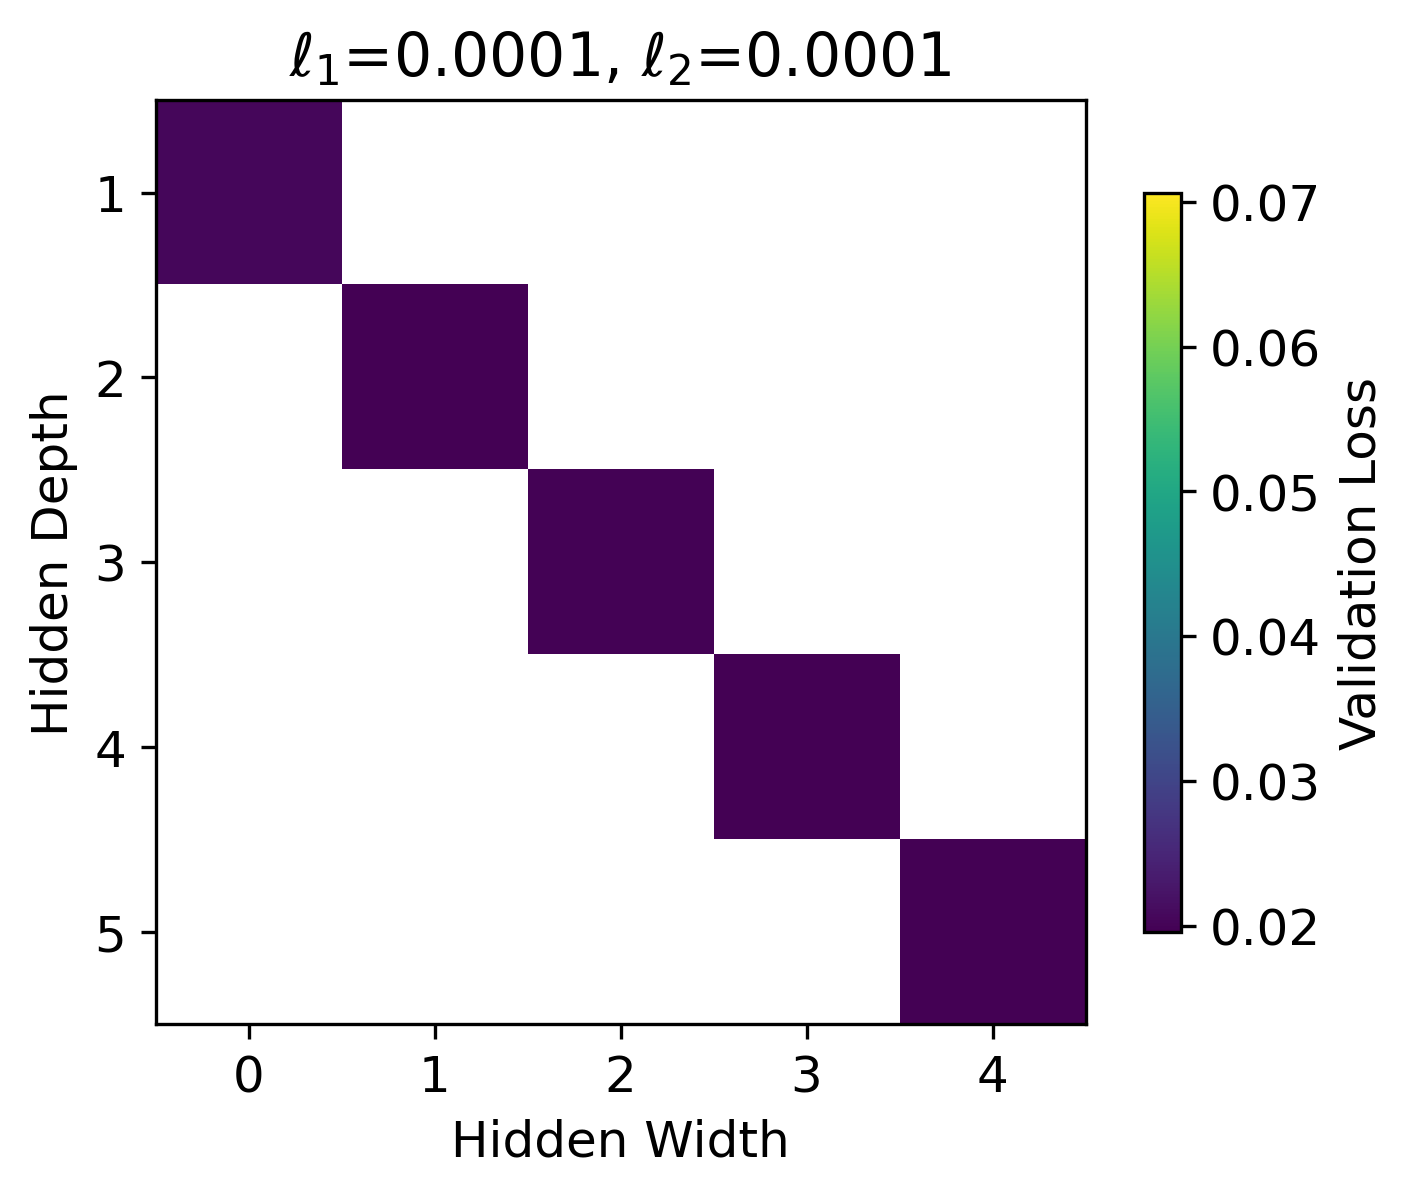

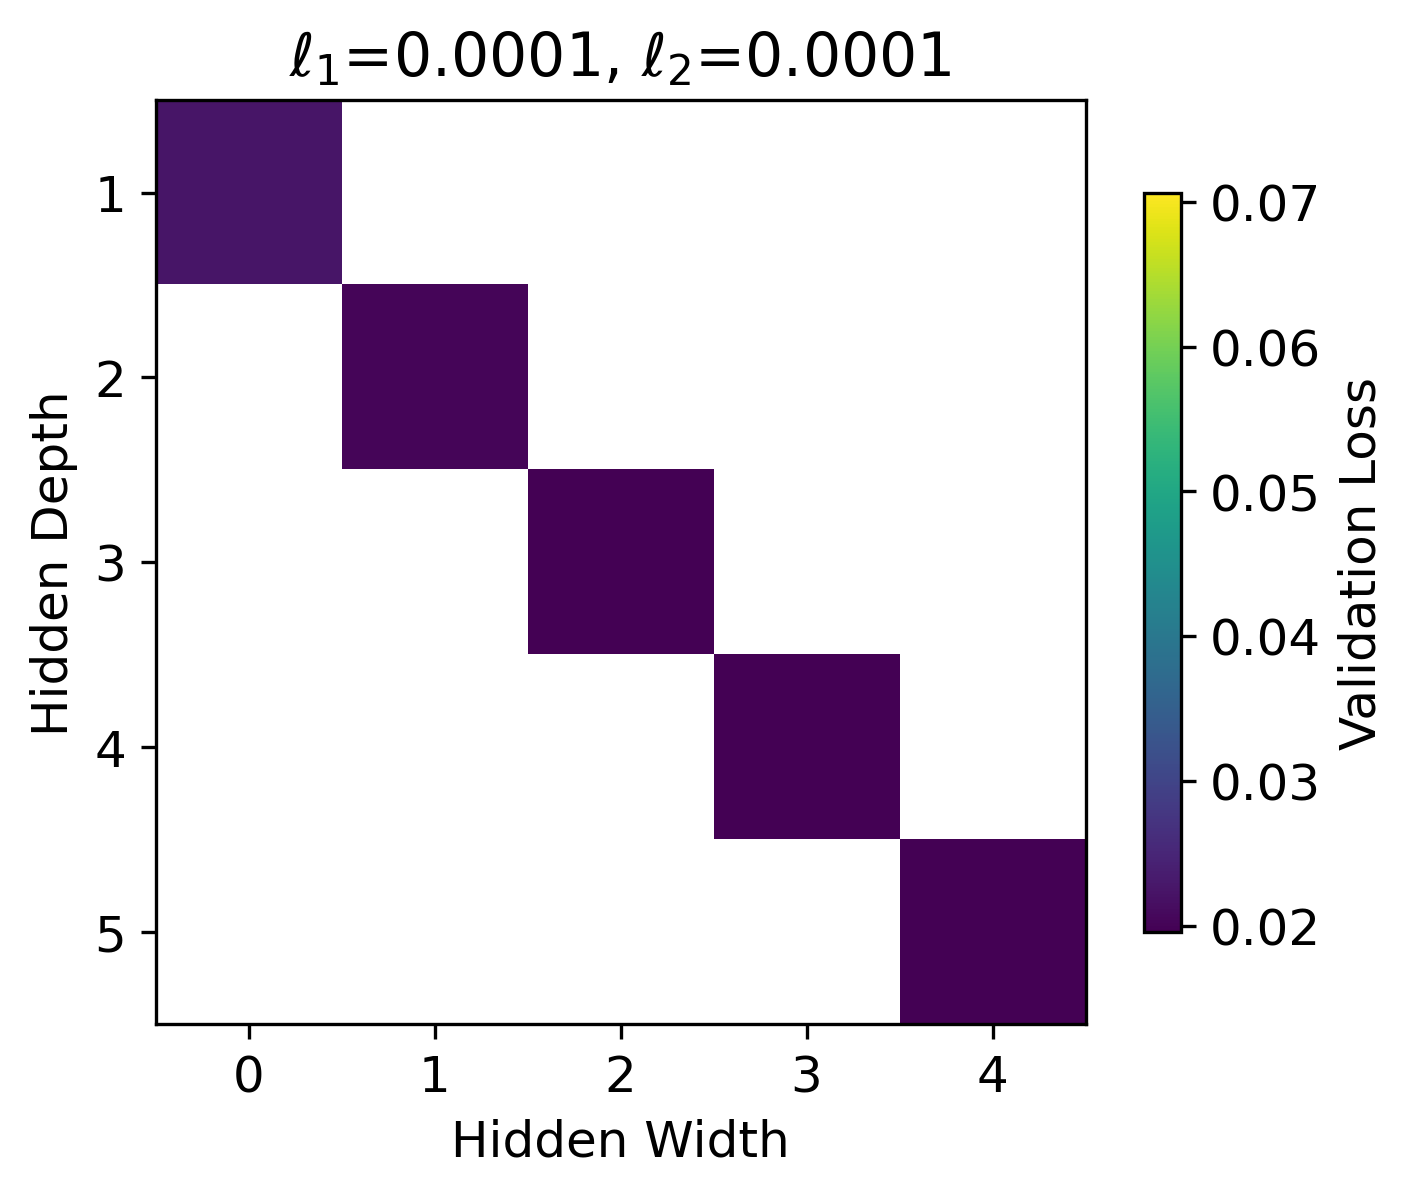

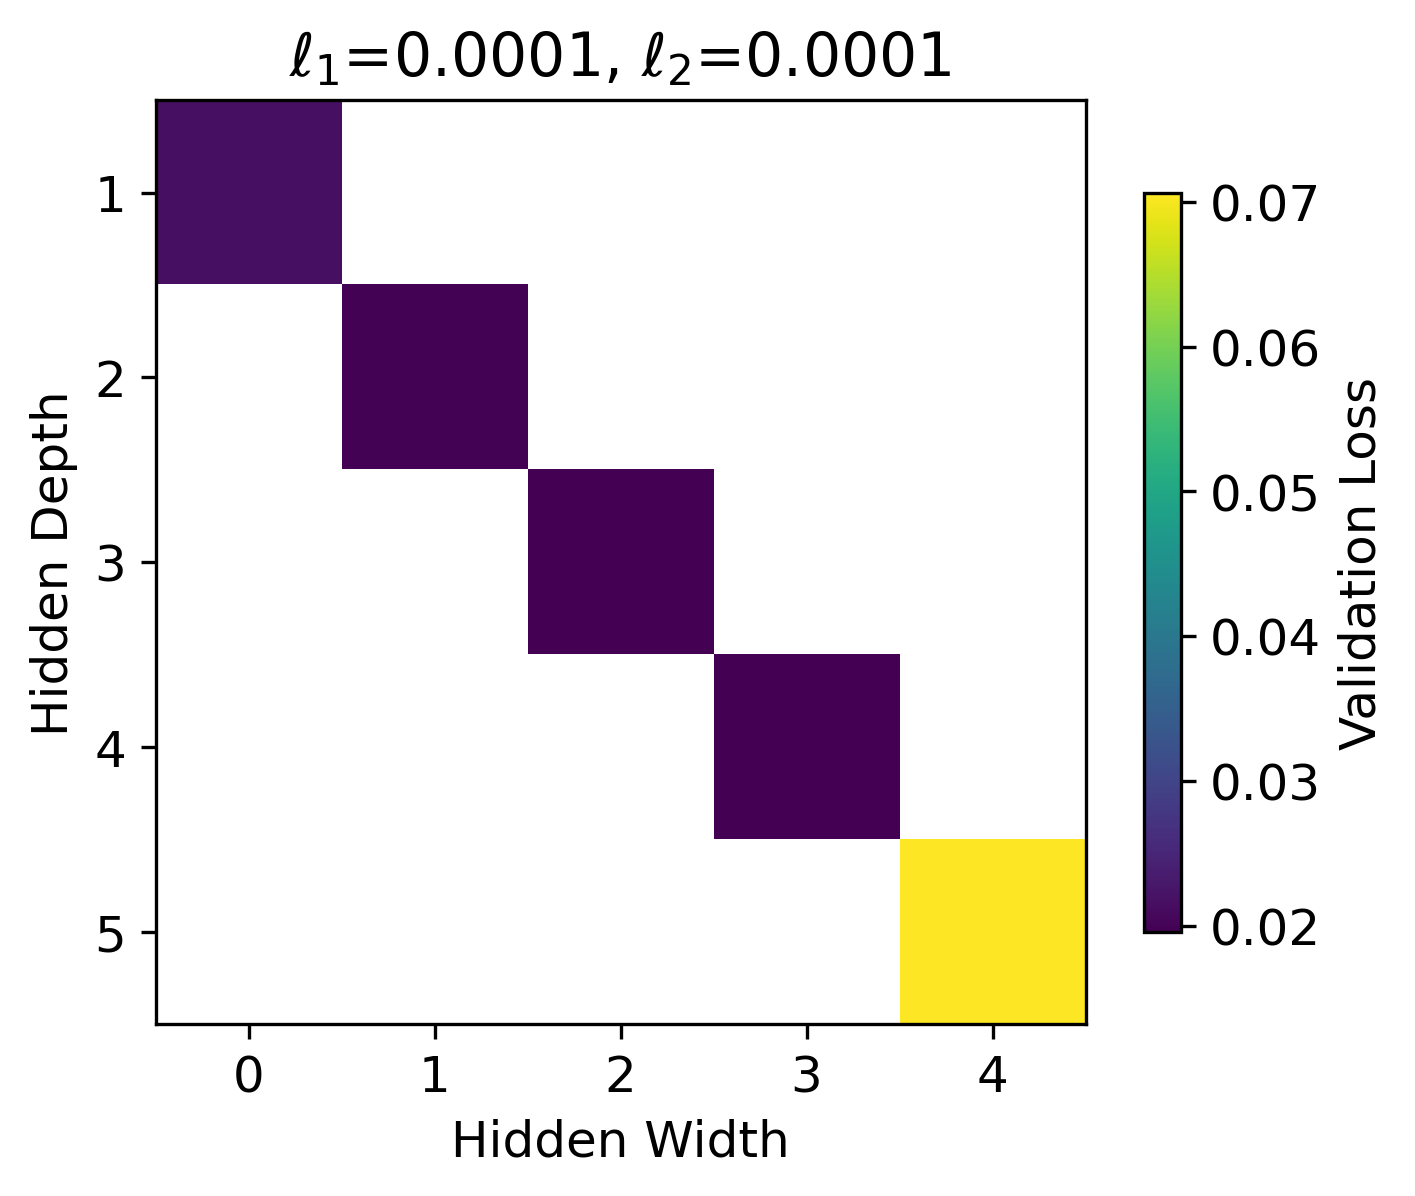

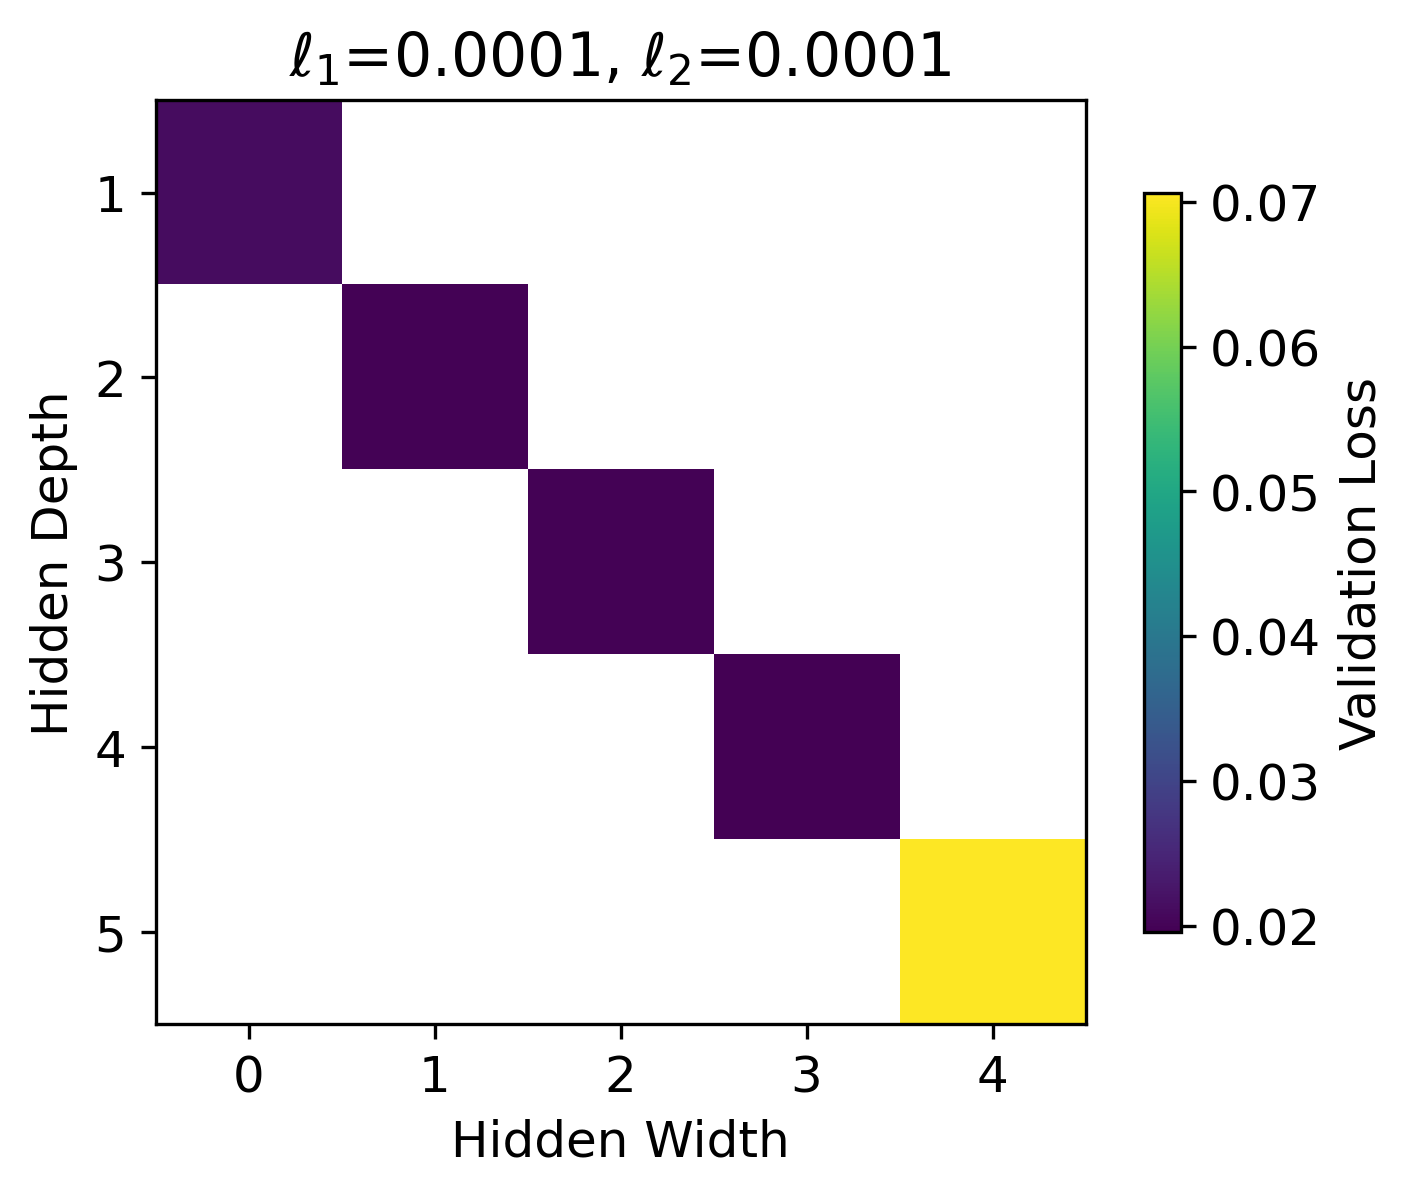

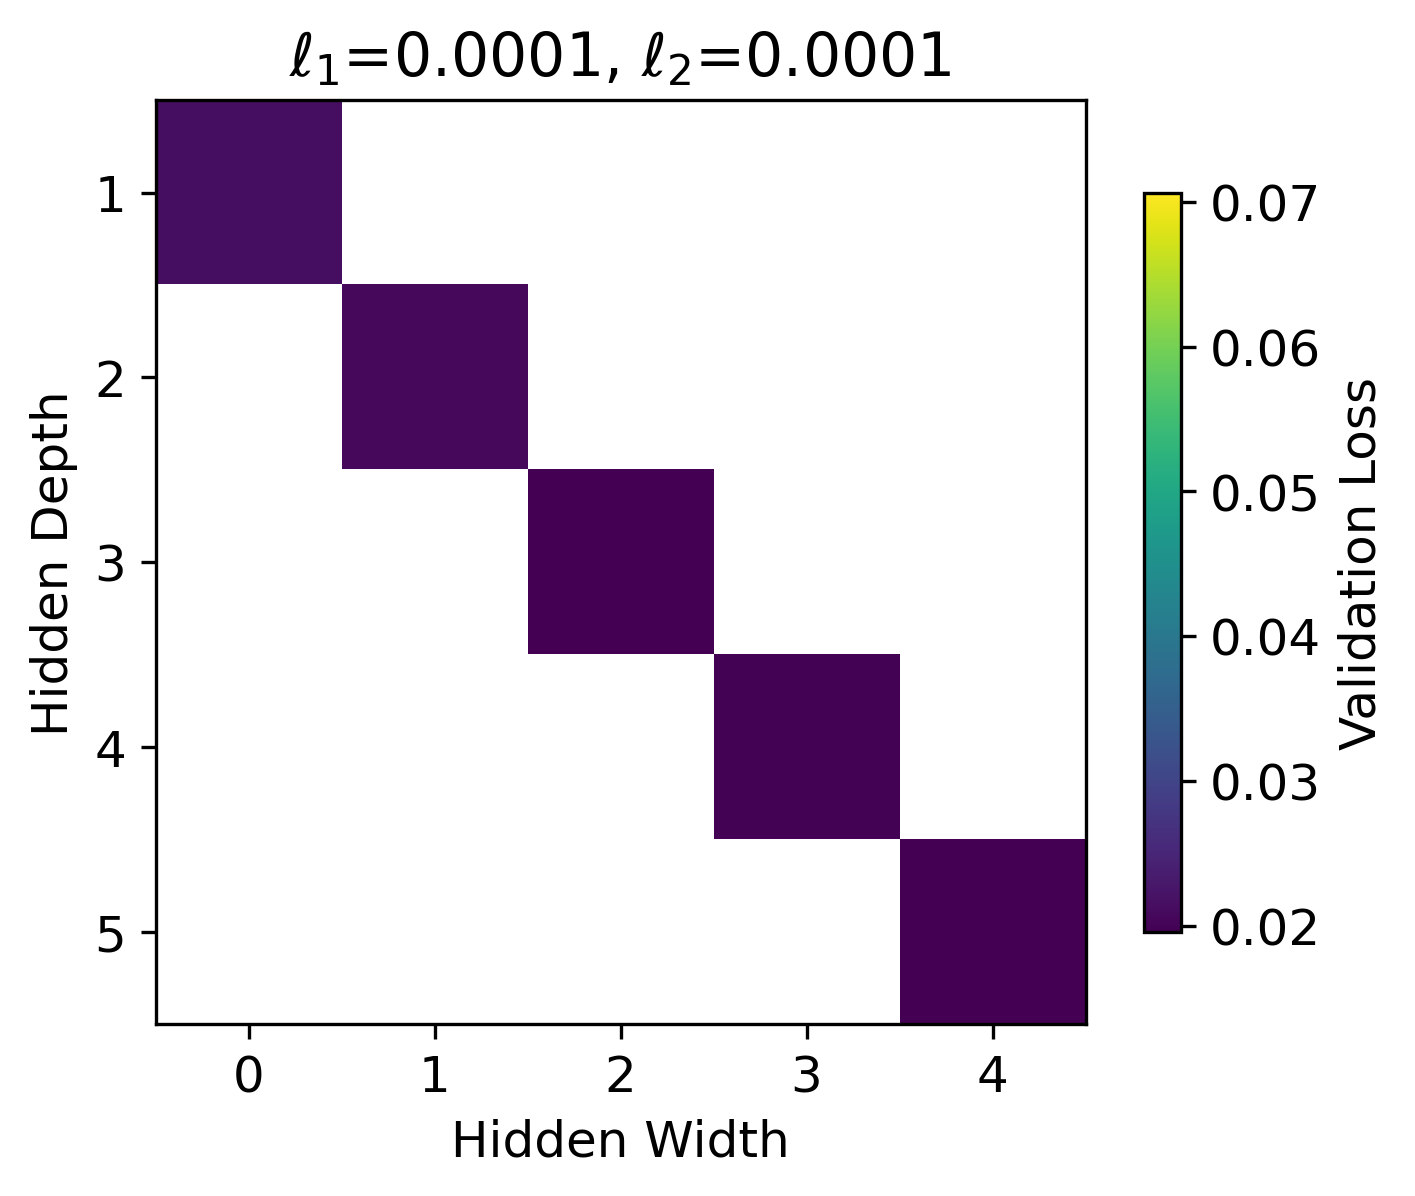

In [ ]:
n_l1 = len(l1_space)
n_l2 = len(l2_space)


# first pass: build and collect all the loss‐matrices so we can compute a global vmin/vmax
all_losses = []
loss_matrices = [[None]*n_l2 for _ in range(n_l1)]
for i, lambda_l1 in enumerate(l1_space):
    for j, lambda_l2 in enumerate(l2_space):
        mat = np.full((len(width_space), len(width_space)),np.nan)
        for wj, hidden_width in enumerate(width_space):
            hidden_depth = len(hidden_width)
            di = hidden_depth - 1
            name = (
                f"l1{lambda_l1}_l2{lambda_l2}"
                f"_drop{dropout_space[0]}_lr{learning_rate_space[0]}"
                f"_w{hidden_width}_d{hidden_depth}_run{run+1}"
            )
            model = best_models_pyramid[name]
            model.eval()
            losses = []
            with torch.no_grad():
                for Xb, yb in val_loader:
                    Xb, yb = Xb.to(device), yb.to(device)
                    yp     = model(Xb)
                    losses.append(criterion(yp, yb).item())
            mat[di, wj] = np.mean(losses)
        loss_matrices[i][j] = mat
        all_losses.append(mat)

# global min/max
# vmin = np.min(np.where(np.array(all_losses) > 0, all_losses, np.inf))
# vmax = np.max(np.where(np.array(all_losses) > 0, all_losses, -np.inf))
# pick a center low in the range to "stretch" the bottom end
vcenter = vmin + 0.5*(vmax - vmin)

norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'viridis'

fig, axes = plt.subplots(n_l1, n_l2, figsize=(5 * n_l2, 4 * n_l1), squeeze=False)

for i in range(n_l1):
    for j in range(n_l2):
        ax = axes[i, j]
        mat = loss_matrices[i][j]
        im = ax.imshow(mat, aspect='auto', cmap=cmap, norm=norm)

        # ticks & labels
        ax.set_xticks(np.arange(len(width_space)))
        # ax.set_xticklabels(width_space)
        ax.set_yticks(np.arange(len(width_space)))
        ax.set_yticklabels(np.arange(len(width_space))+1)

        # only bottom row: show x-axis label
        if i == n_l1 - 1:
            ax.set_xlabel('Hidden Width')
        else:
            ax.tick_params(labelbottom=False)

        # only left column: show y-axis label
        if j == 0:
            ax.set_ylabel('Hidden Depth')
        else:
            ax.tick_params(labelleft=False)

        # title for each panel
        lambda_l1 = l1_space[i]
        lambda_l2 = l2_space[j]
        ax.set_title(f"$\\ell_1$={lambda_l1}, $\\ell_2$={lambda_l2}")

# shared colorbar
cbar = fig.colorbar(im, ax=axes.flatten().tolist(), shrink=0.8)
cbar.set_label('Validation Loss')

# save the figure
fig.savefig('figs/valloss_heat_size.png', dpi=300)

# plt.tight_layout()
plt.show()

/var/folders/yw/jsw5n53s1cb1s2q6tt0msrm00000gn/T/ipykernel_33270/1564011903.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


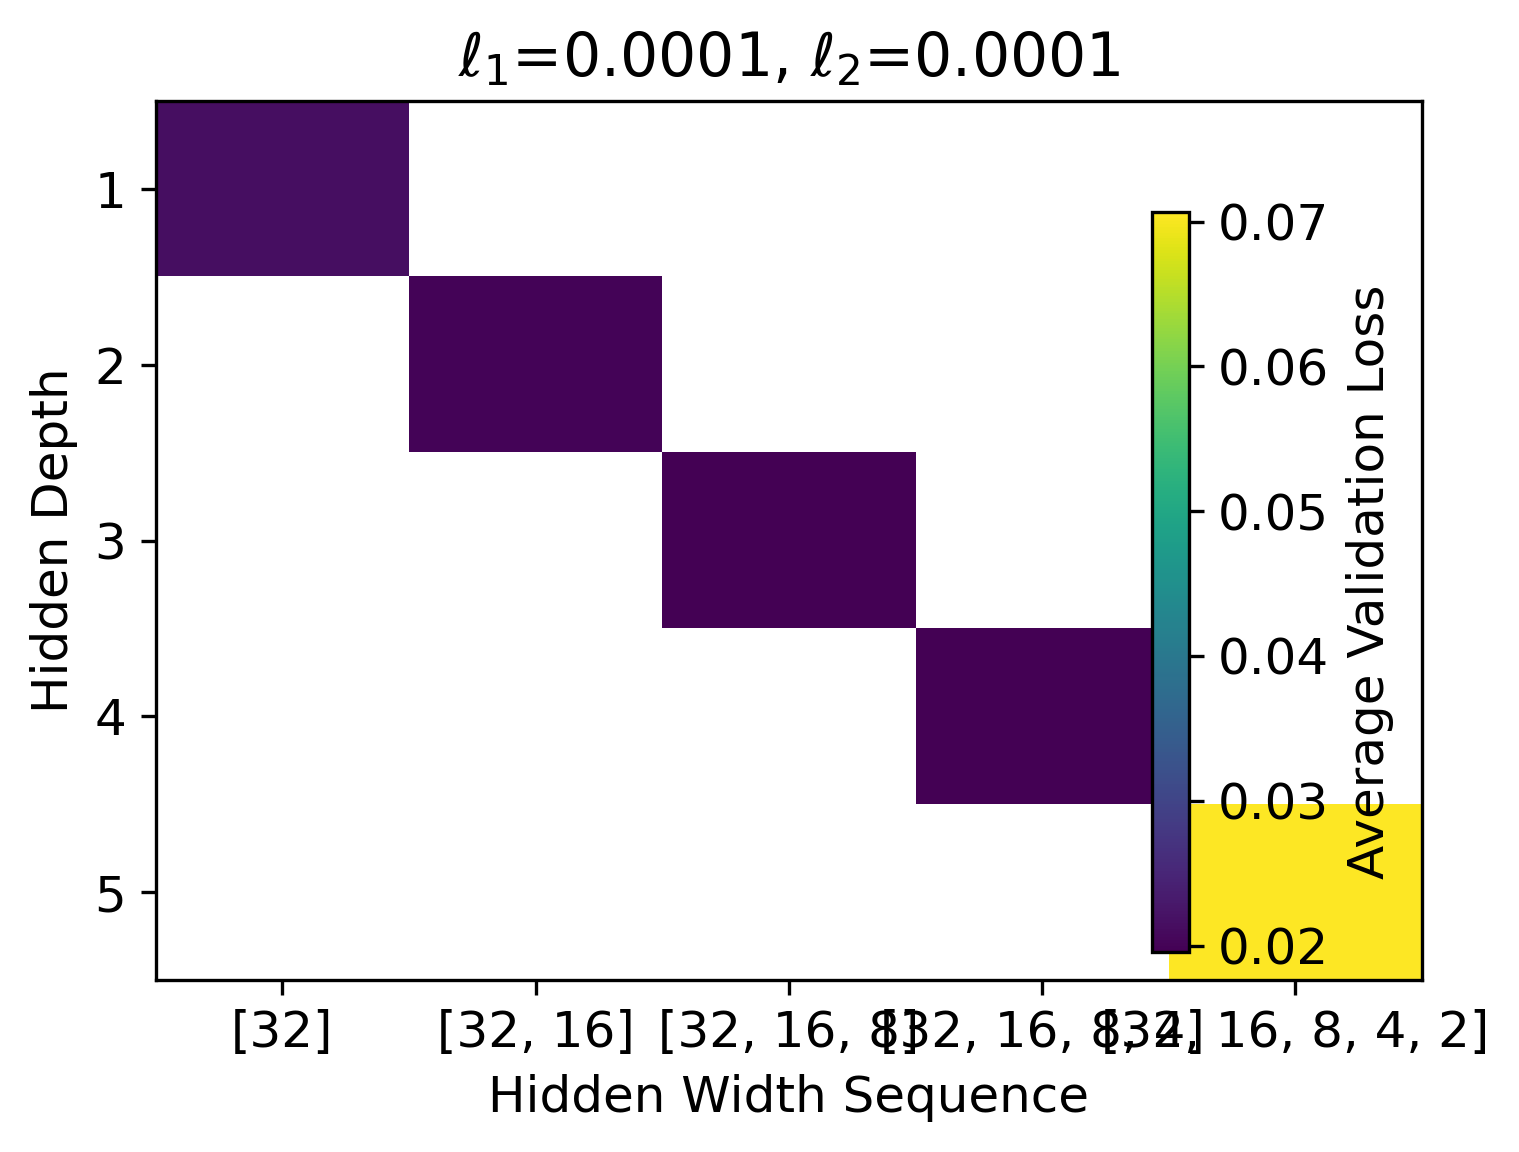

In [101]:
device    = torch.device('cpu')
criterion = nn.MSELoss()

# prepare validation loader once
val_dataset = MLPdataset(X_val[year], y_val[year])
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# load ALL models into a dict, now including the run loop
best_models_pyramid = {}
for dropout in dropout_space:
    for lambda_l2 in l2_space:
        for lambda_l1 in l1_space:
            for learning_rate in learning_rate_space:
                for hidden_width in width_space:
                    hidden_depth = len(hidden_width)
                    for run in range(n_runs):
                        name = (
                            f"l1{lambda_l1}_l2{lambda_l2}"
                            f"_drop{dropout}_lr{learning_rate}"
                            f"_w{hidden_width}_d{hidden_depth}"
                            f"_run{run+1}"
                        )
                        load_path = (
                            f"models/hyperparam_test/mlp_y{year}"
                            f"_l1{lambda_l1}"
                            f"_l2{lambda_l2}"
                            f"_drop{dropout}"
                            f"_lr{learning_rate}"
                            f"_w{hidden_width}"
                            f"_d{hidden_depth}"
                            f"_run{run+1}.pth"
                        )

                        model = MLPModel(
                            input_dim  = X_train[year].shape[1],
                            depth      = hidden_depth,
                            width      = hidden_width,
                            dropout    = dropout,
                            activation = activation_fun,
                        ).to(device)
                        model.load_state_dict(torch.load(load_path, map_location=device))
                        model.eval()
                        best_models_pyramid[name] = model


# now build loss‐matrices, averaging over runs for each (l1, l2, width_seq)
n_l1 = len(l1_space)
n_l2 = len(l2_space)
W    = len(width_space)

all_losses     = []
loss_matrices  = [[None]*n_l2 for _ in range(n_l1)]

for i, lambda_l1 in enumerate(l1_space):
    for j, lambda_l2 in enumerate(l2_space):
        # square matrix: rows=depth (1…W), cols=which width_seq
        mat = np.full((W, W), np.nan)

        for wj, hidden_width in enumerate(width_space):
            hidden_depth = len(hidden_width)
            di = hidden_depth - 1

            # collect this arch’s loss over all runs
            run_losses = []
            for run in range(n_runs):
                name = (
                    f"l1{lambda_l1}_l2{lambda_l2}"
                    f"_drop{dropout_space[0]}_lr{learning_rate_space[0]}"
                    f"_w{hidden_width}_d{hidden_depth}"
                    f"_run{run+1}"
                )
                model = best_models_pyramid[name]
                model.eval()

                losses = []
                with torch.no_grad():
                    for Xb, yb in val_loader:
                        Xb, yb = Xb.to(device), yb.to(device)
                        yp     = model(Xb)
                        losses.append(criterion(yp, yb).item())

                run_losses.append(np.mean(losses))

            mat[di, wj] = np.mean(run_losses)

        loss_matrices[i][j] = mat
        all_losses.append(mat)

# compute global vmin/vmax over all mats
vmin    = np.nanmin(all_losses)
vmax    = np.nanmax(all_losses)
vcenter = vmin + 0.5*(vmax - vmin)
norm    = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap    = 'viridis'

# plot a grid of heatmaps for each (l1, l2)
fig, axes = plt.subplots(n_l1, n_l2,
                         figsize=(5 * n_l2, 4 * n_l1),
                         squeeze=False)

for i in range(n_l1):
    for j in range(n_l2):
        ax  = axes[i, j]
        mat = loss_matrices[i][j]
        im  = ax.imshow(mat, aspect='auto', cmap=cmap, norm=norm)

        # x‐axis: which width sequence
        ax.set_xticks(np.arange(W))
        ax.set_xticklabels(width_space)

        # y‐axis: depth = 1…W
        ax.set_yticks(np.arange(W))
        ax.set_yticklabels(np.arange(1, W+1))

        if i == n_l1 - 1:
            ax.set_xlabel('Hidden Width Sequence')
        else:
            ax.tick_params(labelbottom=False)

        if j == 0:
            ax.set_ylabel('Hidden Depth')
        else:
            ax.tick_params(labelleft=False)

        ax.set_title(f"$\\ell_1$={l1_space[i]}, $\\ell_2$={l2_space[j]}")

# shared colorbar
cbar = fig.colorbar(im, ax=axes.flatten().tolist(), shrink=0.8)
cbar.set_label('Average Validation Loss')

plt.tight_layout()
fig.savefig('figs/valloss_heat_pyramid.png', dpi=300)
plt.show()


In [103]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from torch import nn
from torch.utils.data import DataLoader
from matplotlib.gridspec import GridSpec

device    = torch.device('cpu')
criterion = nn.MSELoss()

# 1) Settings
year              = 2022
lambda_l1         = 0.0001
lambda_l2         = 0.0001
drop              = 0.0
learning_rate     = 1e-3
n_runs            = 5

# constant‐width runs
const_depths  = [1,2,3,4,5,6,7]
const_widths  = [  8, 16, 32, 64, 128]

# pyramid runs (width sequences)
pyr_seqs     = [
    [32],
    [32,16],
    [32,16,8],
    [32,16,8,4],
    [32,16,8,4,2]
]
W_const = len(const_widths)
W_pyr   = len(pyr_seqs)

# build a single validation loader
val_ds     = MLPdataset(X_val[year], y_val[year])
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)

# helper to load & eval one model
def load_model(width, depth, run):
    m = MLPModel(
        input_dim  = X_train[year].shape[1],
        depth      = depth,
        width      = width,
        dropout    = drop,
        activation = activation_fun,
    ).to(device)
    path = (
        f"models/hyperparam_test/mlp_y{year}"
        f"_l1{lambda_l1}_l2{lambda_l2}"
        f"_drop{drop}_lr{learning_rate}"
        f"_w{width}_d{depth}_run{run+1}.pth"
    )
    m.load_state_dict(torch.load(path, map_location=device))
    m.eval()
    return m

# 2) Compute constant‐width loss matrix: depths×widths
loss_const = np.zeros((len(const_depths), W_const))
for di, d in enumerate(const_depths):
    for wj, w in enumerate(const_widths):
        losses = []
        for run in range(n_runs):
            m = load_model(w, d, run)
            with torch.no_grad():
                batch_losses = [criterion(m(x.to(device)), y.to(device)).item()
                                for x,y in val_loader]
            losses.append(np.mean(batch_losses))
        loss_const[di, wj] = np.mean(losses)

# 3) Compute pyramid loss matrix: rows=depth (1…W_pyr), cols=which seq
loss_pyr = np.full((W_pyr, W_pyr), np.nan)
for sj, seq in enumerate(pyr_seqs):
    depth = len(seq)
    for run in range(n_runs):
        m = load_model(seq, depth, run)
        with torch.no_grad():
            batch_losses = [criterion(m(x.to(device)), y.to(device)).item()
                            for x,y in val_loader]
        loss_pyr[depth-1, sj] = (
            loss_pyr[depth-1, sj]
            if np.isfinite(loss_pyr[depth-1, sj])
            else 0.0
        ) + np.mean(batch_losses)/n_runs

# extract the “diagonal” (loss at full depth for each seq)
diag_pyr = np.diag(loss_pyr)  # length = W_pyr

# 4) find global vmin/vmax for the heatmap
all_losses = np.concatenate([loss_const.flatten(), loss_pyr[np.isfinite(loss_pyr)]])
vmin    = all_losses.min()
vmax    = all_losses.max()
vcenter = vmin + 0.5*(vmax - vmin)
norm    = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap    = 'viridis'

# 5) plot
fig = plt.figure(figsize=(12,5))
gs  = GridSpec(1, 2, width_ratios=[4,1], wspace=0.4, figure=fig)

# --- left: constant‐width heatmap ---
ax0 = fig.add_subplot(gs[0,0])
im  = ax0.imshow(loss_const, aspect='auto', cmap=cmap, norm=norm)
ax0.set_xticks(np.arange(W_const))
ax0.set_xticklabels(const_widths)
ax0.set_yticks(np.arange(len(const_depths)))
ax0.set_yticklabels(const_depths)
ax0.set_xlabel('Hidden Width')
ax0.set_ylabel('Hidden Depth')
ax0.set_title(f'Constant width: ℓ₁={lambda_l1}, ℓ₂={lambda_l2}')

# colorbar
cbar = fig.colorbar(im, ax=ax0, shrink=0.8)
cbar.set_label('Average Validation Loss')

# --- right: compressed pyramid line ---
ax1 = fig.add_subplot(gs[0,1])
x = np.arange(W_pyr)
ax1.plot(x, diag_pyr, marker='o', linestyle='-')
ax1.set_xticks(x)
ax1.set_xticklabels(
    [str(seq) for seq in pyr_seqs],
    rotation=45, ha='right'
)
ax1.set_ylabel('Avg. Validation Loss')
ax1.set_title('Pyramid (diagonal)')

plt.tight_layout()
plt.savefig('figs/combined_heat_vs_pyramid.png', dpi=300)
plt.show()


KeyError: 2022

## Regularization strength

In [81]:
# training model with most data on multiple parameters
l1_space = [0.0, 1e-4, 1e-3, 1e-2] # [0.0]
l2_space = [0.0, 1e-4, 1e-3, 1e-2] # [1e-4, 1e-3, 5e-3, 1e-2] # np.geomspace(1e-4, 1e-2, num=4)
dropout_space = [0.0, 0.1, 0.2, 0.3] # np.geomspace(0.0, 0.3, num=4)
learning_rate_space = [learning_rate] # np.geomspace(1e-4, 5e-3, num=4)
depth_space = [5] # [1, 2, 3]
width_space = [32] # [32, 64, 128]

In [82]:
best_models_reg = {}
history_reg = {}
for lambda_l1 in l1_space:
    for lambda_l2 in l2_space:
        for dropout in dropout_space:
            for learning_rate in learning_rate_space:
                for hidden_depth in depth_space:
                    for hidden_width in width_space:
                        np.random.seed(42)
                        torch.manual_seed(42)
                        print(f"""Training model for year '{year}...: 
                                lambda_l1       ={lambda_l1:.0e}
                                lambda_l2       ={lambda_l2:.0e}
                                dropout         ={dropout:.0e}
                                learning_rate   ={learning_rate:.0e}
                                hidden_depth    ={hidden_depth}
                                hidden_width    ={hidden_width}""")
                        # Initialize the model
                        input_dim = X_train[year].shape[1]
                        name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}'
                        models_21[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
                        optimizer = torch.optim.Adam(models_21[name].parameters(), lr=learning_rate)
                        train = MLPdataset(X_train[year], y_train[year])
                        val = MLPdataset(X_val[year], y_val[year])
                        best_models_reg[name], history_reg[name] = train_mlp(train,          
                                                        val,
                                                        models_21[name],
                                                        criterion,
                                                        epochs,
                                                        patience,
                                                        print_freq,
                                                        device,
                                                        optimizer,
                                                        lambda_l1=lambda_l1,
                                                        lambda_l2=lambda_l2,
                                                        batch_size=batch_size,
                                                        shuffle_train=True,
                                                        shuffle_val=False,
                                                        save_path=f'models/hyperparam_test/mlp_y{year}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}.pth'
                                                        )

Training model for year '21...: 
                                lambda_l1       =0e+00
                                lambda_l2       =0e+00
                                dropout         =0e+00
                                learning_rate   =1e-04
                                hidden_depth    =5
                                hidden_width    =32
Early stopping at epoch 77
Best val loss: 1.96319E-02
Model saved to models/hyperparam_test/mlp_y21_l10.0_l20.0_drop0.0_lr0.0001_w32_d5.pth
Training model for year '21...: 
                                lambda_l1       =0e+00
                                lambda_l2       =0e+00
                                dropout         =1e-01
                                learning_rate   =1e-04
                                hidden_depth    =5
                                hidden_width    =32
Early stopping at epoch 79
Best val loss: 1.97842E-02
Model saved to models/hyperparam_test/mlp_y21_l10.0_l20.0_drop0.1_lr0.0001_w32_d5.pth
Training

In [83]:
device = torch.device('cpu')
criterion = nn.MSELoss()
val = MLPdataset(X_val[year], y_val[year])

# load models

for hidden_depth in depth_space:
    for hidden_width in width_space:
        for dropout in dropout_space:
            for lambda_l2 in l2_space:
                for lambda_l1 in l1_space:
                    for learning_rate in learning_rate_space:
                        name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}'
                        load_path = (
                            f"models/hyperparam_test/mlp_y{year}"
                            f"_l1{lambda_l1}"
                            f"_l2{lambda_l2}"
                            f"_drop{dropout}"
                            f"_lr{learning_rate}"
                            f"_w{hidden_width}"
                            f"_d{hidden_depth}.pth"
                        )
                        model = MLPModel(
                            input_dim  = X_train[year].shape[1],
                            depth      = hidden_depth,
                            width      = hidden_width,
                            dropout    = dropout,
                            activation = activation_fun,
                        ).to(device)
                        model.load_state_dict(torch.load(load_path, map_location=device))
                        model.eval()
                        best_models_reg[name] = model

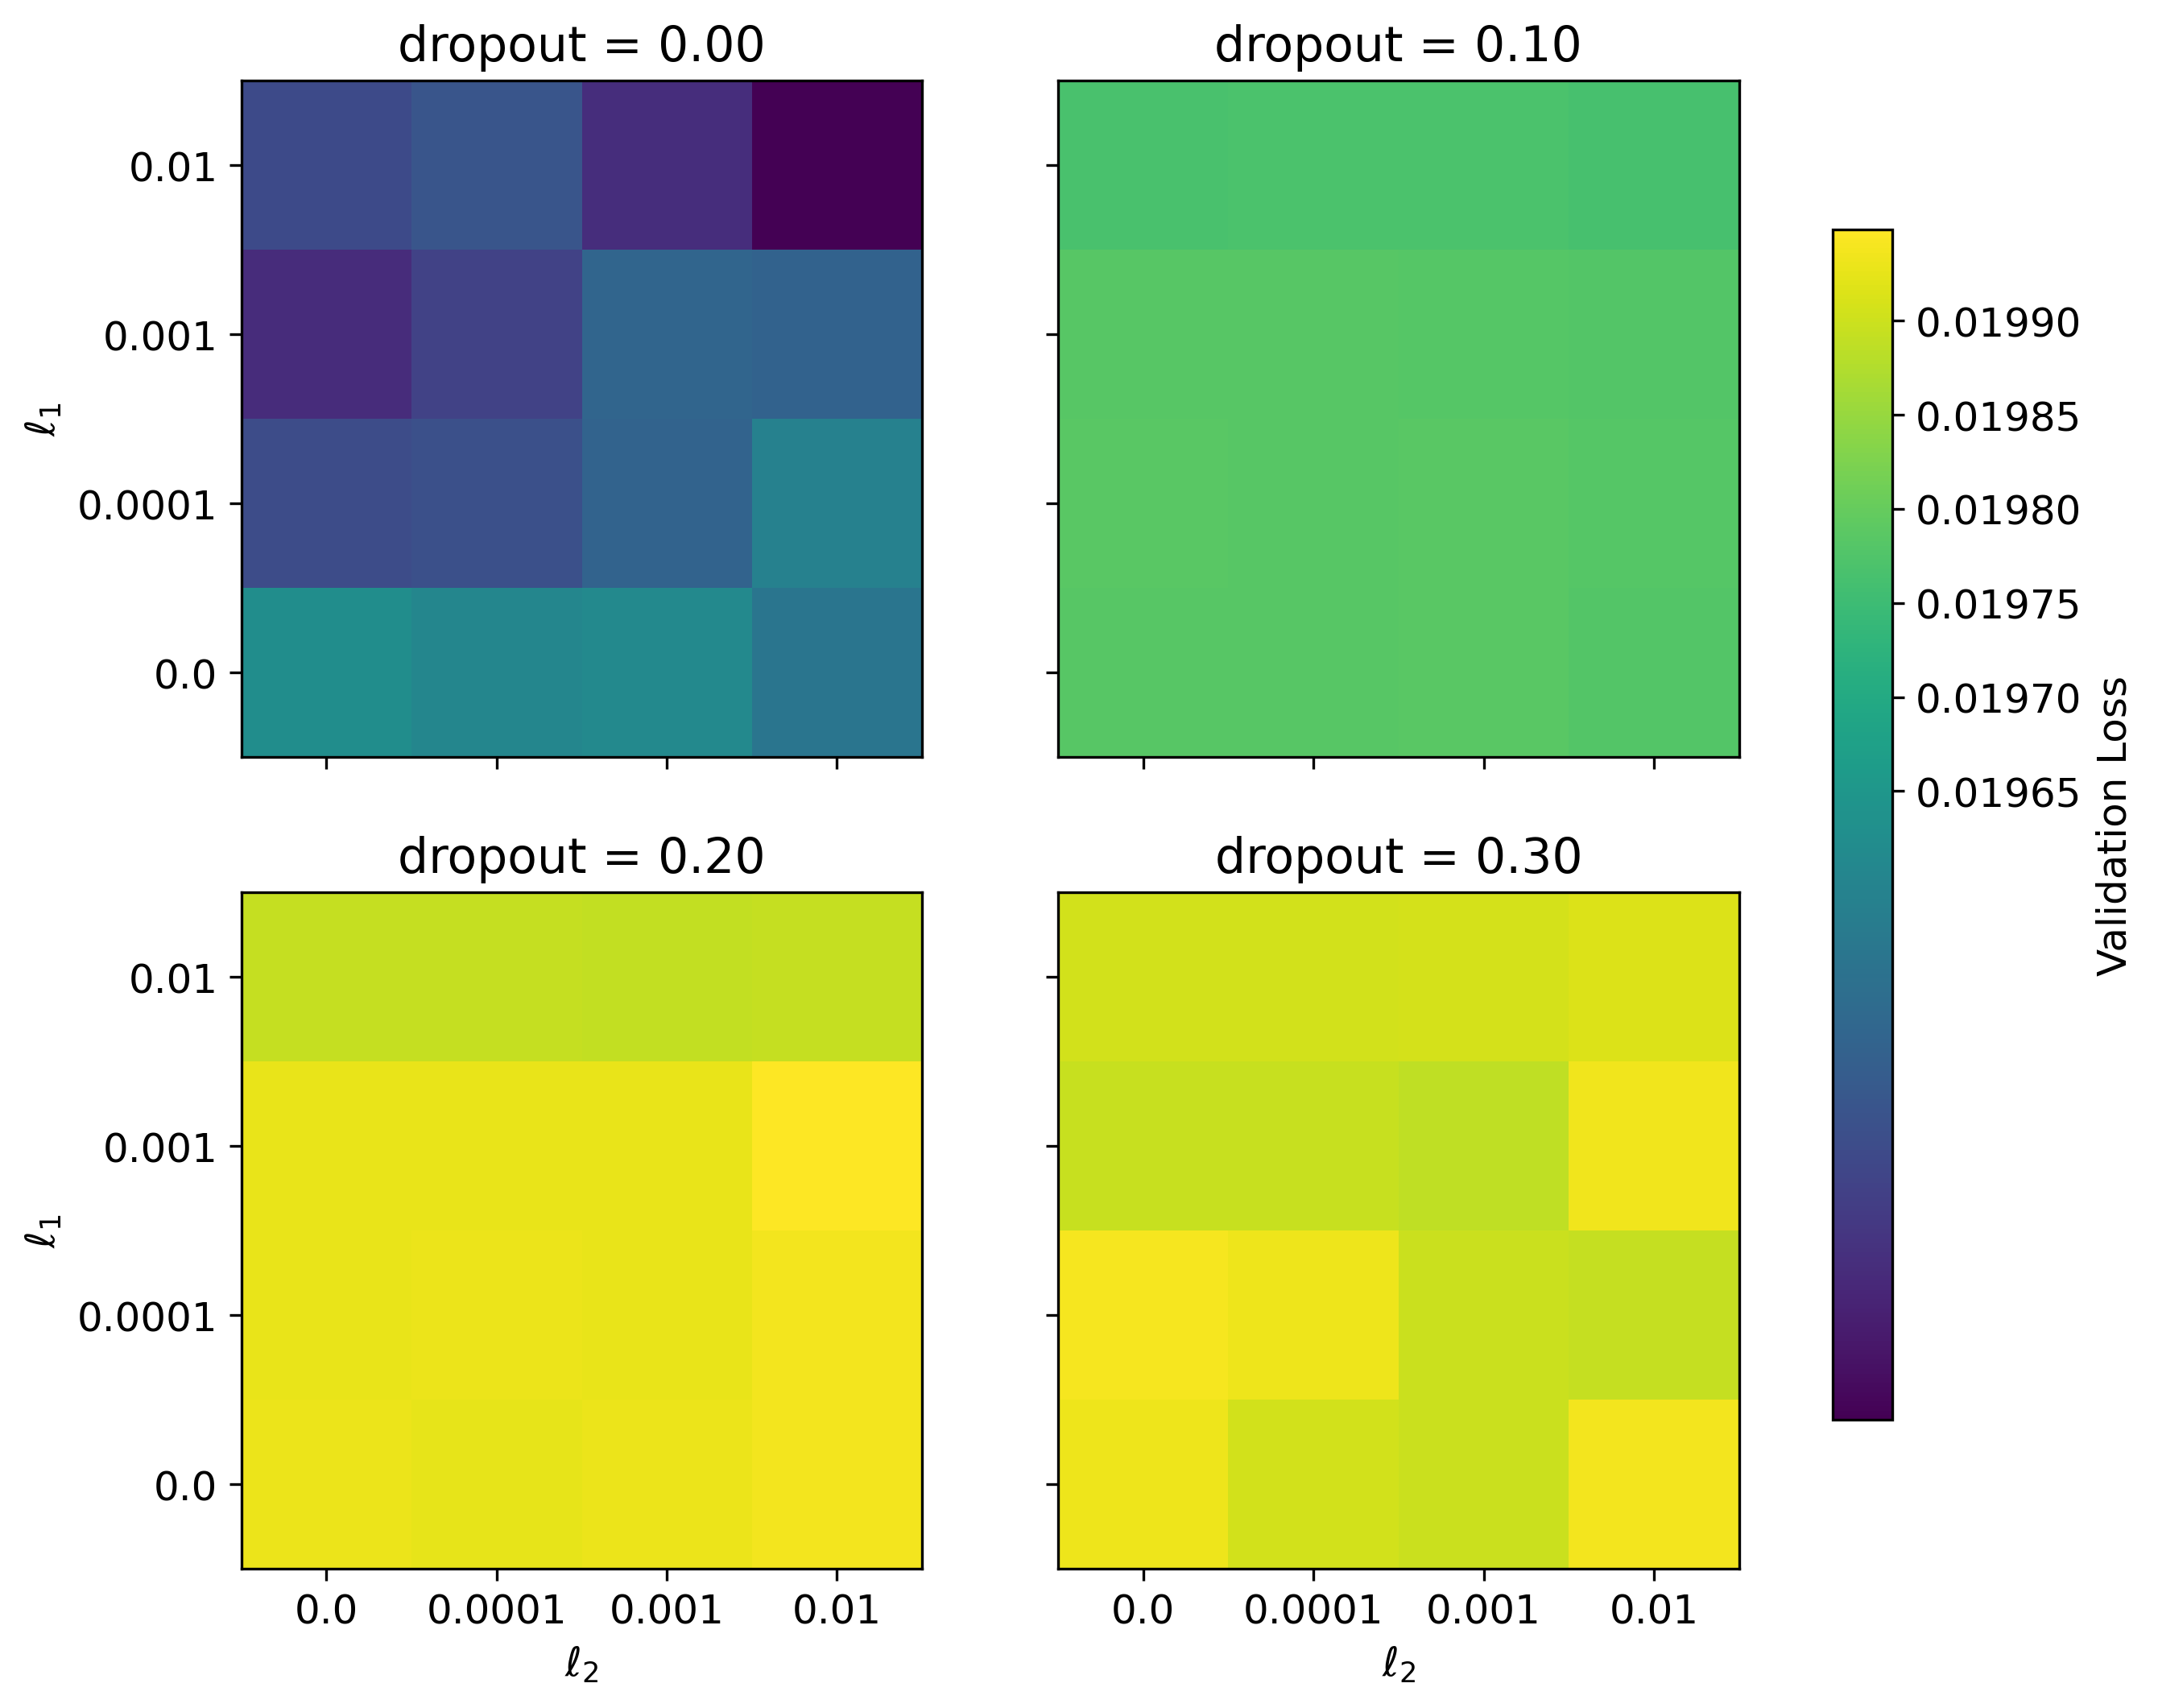

In [84]:
n_l1   = len(l1_space)
n_l2   = len(l2_space)
n_drop = len(dropout_space)

# 1) Build (n_drop, n_l1, n_l2) mean‐loss array (same as before)
losses = np.zeros((n_drop, n_l1, n_l2))
for di, dropout in enumerate(dropout_space):
    for i, lambda_l1 in enumerate(l1_space):
        for j, lambda_l2 in enumerate(l2_space):
            tmp = []
            for hidden_depth in depth_space:
                for hidden_width in width_space:
                    name = (
                        f"l1{lambda_l1}_l2{lambda_l2}"
                        f"_drop{dropout}_lr{learning_rate_space[0]}"
                        f"_w{hidden_width}_d{hidden_depth}"
                    )
                    model = best_models_reg[name]
                    model.eval()
                    batch_losses = []
                    with torch.no_grad():
                        for Xb, yb in val_loader:
                            Xb, yb = Xb.to(device), yb.to(device)
                            yp     = model(Xb)
                            batch_losses.append(criterion(yp, yb).item())
                    tmp.append(np.mean(batch_losses))
            losses[di, i, j] = np.mean(tmp)

# 2) global color‐scale
vmin    = losses.min()
vmax    = losses.max()
vcenter = vmin + 0.05*(vmax - vmin)
norm    = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap    = 'viridis'

# 3) layout: at most 3 columns
ncols = min(2, n_drop)
nrows = math.ceil(n_drop / ncols)

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(5*ncols, 4*nrows),
                         squeeze=False)
axes_flat = axes.flatten()

for idx, dropout in enumerate(dropout_space):
    ax = axes_flat[idx]
    im = ax.imshow(
        losses[idx],
        aspect='auto',
        cmap=cmap,
        norm=norm,
        origin='lower'
    )

    # set yticks = ℓ₁, always
    ax.set_yticks(np.arange(n_l1))
    ax.set_yticklabels(l1_space)

    # set xticks = ℓ₂, but we'll hide them on the first row
    ax.set_xticks(np.arange(n_l2))
    ax.set_xticklabels(l2_space)

    # hide x‐labels & ticks for first‐row subplots
    if idx < ncols:
        ax.tick_params(labelbottom=False)
    else:
        ax.set_xlabel(r'$\ell_2$')

    # only first‐column subplots show y‐label
    if idx % ncols == 0:
        ax.set_ylabel(r'$\ell_1$')
    else:
        ax.tick_params(labelleft=False)

    ax.set_title(f"dropout = {dropout:.2f}")

# remove any unused axes
for ax in axes_flat[n_drop:]:
    fig.delaxes(ax)

# single shared colorbar
cbar = fig.colorbar(im, ax=axes_flat[:n_drop].tolist(), shrink=0.8)
cbar.set_label('Validation Loss')

# plt.tight_layout()
plt.show()
